# Generate Factorizable Joint Shift Dataset
Reproduction code of Algorithm 2 in the paper

## Import required functions and load data

In [1]:
import logging
import torchvision.transforms as transforms
import torchvision
import os
from utils import sample_point_in_simplex, get_plot_images, Umap_transform, get_label_rate, save_FJS_data
import numpy as np
import random
import torch
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UserWarning, module="umap")

logging.basicConfig(level=logging.INFO)
num_class = 10
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
Generate_path = r"data/MNIST/generate"
if not os.path.exists(Generate_path):
    os.makedirs(Generate_path)

## Perform label shift

In [2]:
# Label shift
N_t = len(dataset)
p_m_Y = sample_point_in_simplex(num_class)
h_k = np.cumsum(p_m_Y)
D_s_k = [[] for i in range(num_class)]
for x,y in dataset:
    D_s_k[y].append((x,y))
i = 1
D_m = []
while i <= N_t:
    h = random.uniform(0, 1)
    index = np.searchsorted(h_k, h, side='left')
    D_m.append(random.choice(D_s_k[index]))
    i = i + 1
logging.info("Label shift perform successfully!")

INFO:root:Label shift perform successfully!


## Perform covariate shift

In [3]:
# Covariate shift
p_t_X = sample_point_in_simplex(N_t)
h_J = np.cumsum(p_t_X)
i = 1
D_t_images = []
D_t_labels = []
while i <= N_t:
    h = random.uniform(0, 1)
    index = np.searchsorted(h_J, h, side='left')
    D_t_images.append(D_m[index][0])
    D_t_labels.append(D_m[index][1])
    i = i +1
D_t_images = torch.stack(D_t_images,dim=0)
tensor_transform = v2.Compose([v2.RandomRotation(degrees=10),
                    v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                    v2.RandomCrop(size=26),
                    v2.Resize(28),
                    v2.ColorJitter(brightness=0.1, contrast=0.1)
                    ])
D_t_images = tensor_transform(D_t_images)
save_FJS_data(Generate_path,D_t_images,D_t_labels)
logging.info("Covariate shift perform successfully!")
logging.info("Save FJS data in "+ Generate_path)


INFO:root:Covariate shift perform successfully!
INFO:root:Save FJS data in data/MNIST/generate


## Visualization

UMAP(metric='manhattan', min_dist=0.05, n_jobs=1, n_neighbors=8, random_state=42, spread=2.5, verbose=True)
Tue Jul 15 21:02:28 2025 Construct fuzzy simplicial set
Tue Jul 15 21:02:35 2025 Finding Nearest Neighbors
Tue Jul 15 21:02:40 2025 Finished Nearest Neighbor Search
Tue Jul 15 21:02:43 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jul 15 21:02:46 2025 Finished embedding


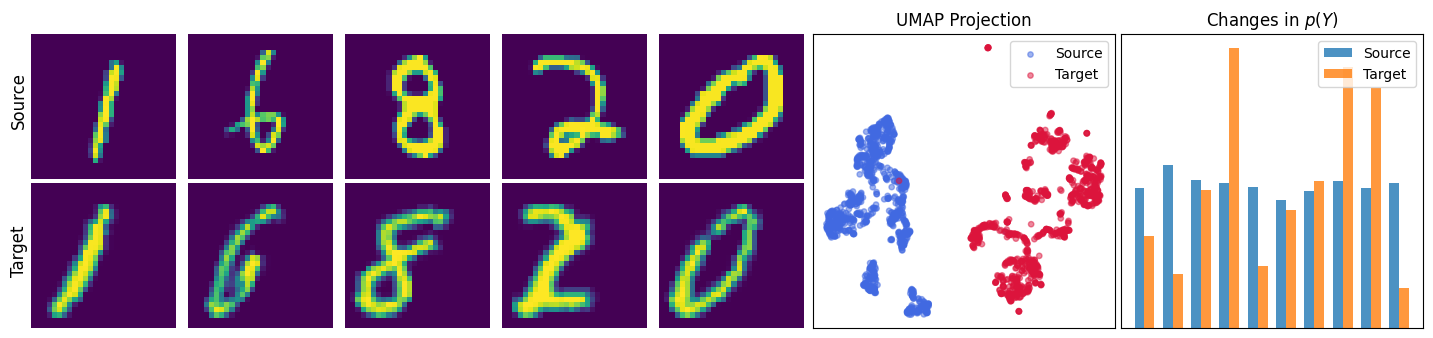

In [4]:
# plot
num_per_row = 5
fig = plt.figure(figsize=(18, 7))
gs  = fig.add_gridspec(2, num_per_row + 2,width_ratios=[1]*num_per_row + [2.]+ [2.],hspace=0.03, wspace=0.03, top = 0.53)
fig.text(0.115,0.435,"Source",va='center',rotation='vertical',fontsize=12)
fig.text(0.115,0.22,"Target",va='center',rotation='vertical',fontsize=12)

# -------------------------plot genereted images------------------------#
source_plot_images, source_images, source_labels, class_images_idx = get_plot_images(None,None,None,dataset=dataset)
target_plot_images,_ = get_plot_images(D_t_images, D_t_labels, class_images_idx=class_images_idx)
for i, img in enumerate(source_plot_images):
    ax = fig.add_subplot(gs[0, i])
    if len(img.shape) == 2 or img.shape[2] == 3:
        ax.imshow(img,interpolation="nearest")
    else:
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
        else:
            img = img.permute(1,2,0)
        ax.imshow(img,interpolation="nearest")
    ax.axis('off')
for i, img in enumerate(target_plot_images):
    ax = fig.add_subplot(gs[1, i])
    if len(img.shape) == 2 or img.shape[2] == 3:
        ax.imshow(img,interpolation="nearest")
    else:
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
        else:
            img = img.permute(1,2,0)
        ax.imshow(img,interpolation="nearest")
    ax.axis('off')

# -------------------------plot umap------------------------#
embedding, domain_labels = Umap_transform(source_images,source_labels,D_t_images,D_t_labels)
ax_umap = fig.add_subplot(gs[:, -2])
color_map = {0:'royalblue', 1:'crimson'}
colors = [color_map[d] for d in domain_labels]
scatter = ax_umap.scatter(
    embedding[:, 0], embedding[:, 1],
    c=colors, s=15, alpha=0.5)
for domain, color in color_map.items():
    if domain == 0:
        ax_umap.scatter([], [],  # 空数据
                    c=color,
                    s=15,
                    alpha=0.5,
                    label=f'Source')
    else:
        ax_umap.scatter([], [],  # 空数据
                    c=color,
                    s=15,
                    alpha=0.5,
                    label=f'Target')
ax_umap.legend(loc='upper right', frameon=True)
ax_umap.set_title('UMAP Projection', fontsize=12)
ax_umap.set_xticks([])
ax_umap.set_yticks([])

# -------------------------plot label rate------------------------#
label_rate_plot = fig.add_subplot(gs[:, -1])
source_label_rate = get_label_rate(source_labels)
target_label_rate = get_label_rate(D_t_labels)
x = np.arange(len(source_label_rate))
width = 0.35
label_rate_plot.bar(x - width/2, source_label_rate, width, label='Source', color='#1f77b4', alpha=0.8)
label_rate_plot.bar(x + width/2, target_label_rate, width, label='Target', color='#ff7f0e', alpha=0.8)
label_rate_plot.set_xticks([])
label_rate_plot.set_yticks([])
label_rate_plot.legend(loc='upper right')
label_rate_plot.set_title('Changes in $p(Y)$', fontsize=12)

plt.show()